In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
# logistic regression
from sklearn.linear_model import LogisticRegression
# support vector machine
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# classification report
from sklearn.metrics import classification_report

df_sample1 = pd.read_csv('data_ml/SharedResponses_sample1.csv')
df_sample2 = pd.read_csv('data_ml/SharedResponses_sample2.csv')

df_combined = pd.read_csv('data_ml/SharedResponses_combined_two_genders.csv')
df_female = pd.read_csv('data_ml/SharedResponses_female.csv')
df_male = pd.read_csv('data_ml/SharedResponses_male.csv')

In [6]:
df_list = [df_sample1, df_sample2, df_combined, df_female, df_male]

for df in df_list:
    df.dropna(inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1029 entries, 0 to 1231
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ResponseID               1029 non-null   object 
 1   ExtendedSessionID        1029 non-null   object 
 2   UserID                   1029 non-null   int64  
 3   ScenarioOrder            1029 non-null   int64  
 4   Intervention             1029 non-null   int64  
 5   PedPed                   1029 non-null   int64  
 6   Barrier                  1029 non-null   int64  
 7   CrossingSignal           1029 non-null   int64  
 8   AttributeLevel           1029 non-null   object 
 9   ScenarioTypeStrict       1029 non-null   object 
 10  ScenarioType             1029 non-null   object 
 11  DefaultChoice            1029 non-null   object 
 12  NonDefaultChoice         1029 non-null   object 
 13  DefaultChoiceIsOmission  1029 non-null   float64
 14  NumberOfCharacters       1029

In [9]:
i = 1

for df in df_list:

    print('the {}th dataset'.format(i))

    df_x = df.iloc[:, 3:-2]
    df_y = df['Saved']
    df_x = df_x.drop(['Saved'], axis=1)
    df_x = df_x.apply(lambda x: pd.to_numeric(x, errors='coerce'))

    # deal with inf and -inf
    df_x = df_x.replace([float('inf'), float('-inf')], float('nan'))

    # deal with too large values
    df_x = df_x.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
    df_x = df_x.dropna(axis=1)

    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=0)

    # Random Forest
    model = RandomForestClassifier()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print('Random Forest')
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Logistic Regression
    model = LogisticRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print('Logistic Regression')
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print('--------------------------------------')
    i += 1



the 1th dataset
Random Forest
0.6915520628683693
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       257
           1       0.73      0.60      0.66       252

    accuracy                           0.69       509
   macro avg       0.70      0.69      0.69       509
weighted avg       0.70      0.69      0.69       509

Logistic Regression
0.7092337917485265
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       257
           1       0.75      0.62      0.68       252

    accuracy                           0.71       509
   macro avg       0.71      0.71      0.71       509
weighted avg       0.71      0.71      0.71       509

--------------------------------------
the 2th dataset
Random Forest
0.7279843444227005
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       276
           1       0.71      0.69      0.70       235

    ac

Random Forest
0.715311004784689
              precision    recall  f1-score   support

           0       0.71      0.76      0.74       219
           1       0.72      0.66      0.69       199

    accuracy                           0.72       418
   macro avg       0.72      0.71      0.71       418
weighted avg       0.72      0.72      0.71       418



100%|===================| 834/836 [00:29<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


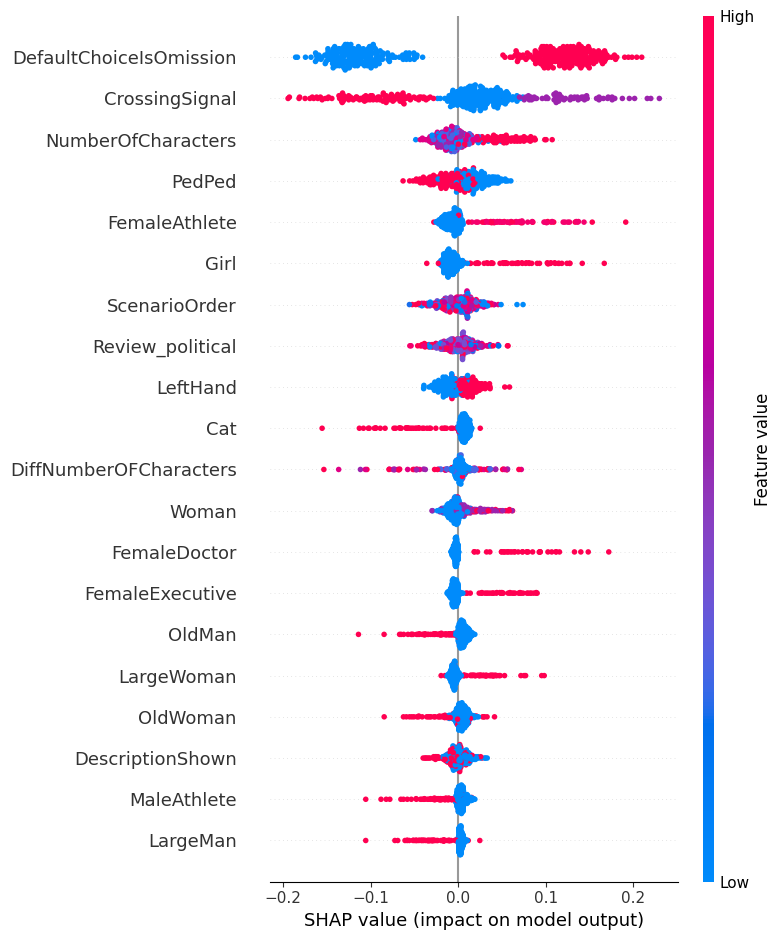

In [19]:
import shap

df_x_combined = df_combined.iloc[:, 3:-2]
df_y_combined = df_combined['Saved']
df_x_combined = df_x_combined.drop(['Saved'], axis=1)
df_x_combined = df_x_combined.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# deal with inf and -inf
df_x_combined = df_x_combined.replace([float('inf'), float('-inf')], float('nan'))

# deal with too large values
df_x_combined = df_x_combined.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
df_x_combined = df_x_combined.dropna(axis=1)

x_train_combined, x_test_combined, y_train_combined, y_test_combined = train_test_split(df_x_combined, df_y_combined, test_size=0.2, random_state=0)

model_combined = RandomForestClassifier()
model_combined.fit(x_train_combined, y_train_combined)

# print classification report
y_pred_combined = model_combined.predict(x_test_combined)
print('Random Forest')
print(accuracy_score(y_test_combined, y_pred_combined))
print(classification_report(y_test_combined, y_pred_combined))

# Create a SHAP explainer

explainer = shap.Explainer(model_combined, x_train_combined)

# Calculate SHAP values
shap_values = explainer(x_test_combined, check_additivity=False)

# print(type(shap_values))
# print(shap_values.shape)

# print(type(x_test_combined))
# print(x_test_combined.shape)
shap_values_positive_class = shap_values.values[...,1]

# Now you can plot the summary plot for the positive class
shap.summary_plot(shap_values_positive_class, x_test_combined)
# shap.summary_plot(shap_values, x_test_combined)

Random Forest
0.7129186602870813
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       219
           1       0.71      0.67      0.69       199

    accuracy                           0.71       418
   macro avg       0.71      0.71      0.71       418
weighted avg       0.71      0.71      0.71       418



 98%|===================| 818/836 [00:29<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


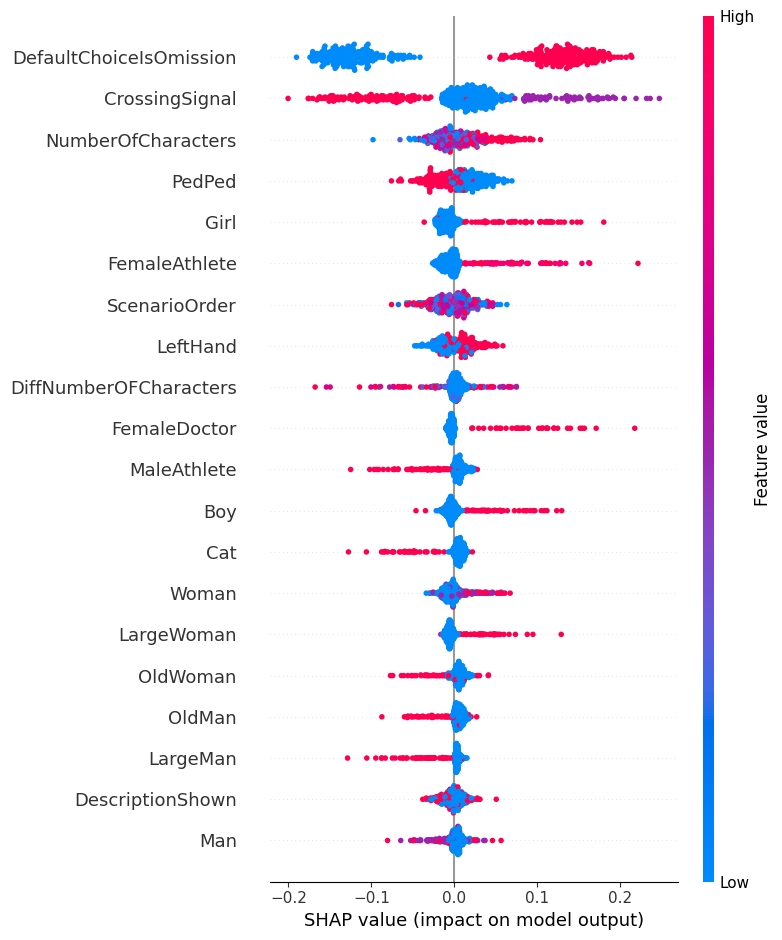

In [20]:
# drop column Review_political
df_x_combined = df_combined.iloc[:, 3:-3]
df_y_combined = df_x_combined['Saved']
df_x_combined = df_x_combined.drop(['Saved'], axis=1)
df_x_combined = df_x_combined.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# deal with inf and -inf
df_x_combined = df_x_combined.replace([float('inf'), float('-inf')], float('nan'))

# deal with too large values
df_x_combined = df_x_combined.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
df_x_combined = df_x_combined.dropna(axis=1)


x_train_combined, x_test_combined, y_train_combined, y_test_combined = train_test_split(df_x_combined, df_y_combined, test_size=0.2, random_state=0)

model_combined = RandomForestClassifier()
model_combined.fit(x_train_combined, y_train_combined)

y_pred_combined = model_combined.predict(x_test_combined)
print('Random Forest')
print(accuracy_score(y_test_combined, y_pred_combined))
print(classification_report(y_test_combined, y_pred_combined))

# Create a SHAP explainer

explainer = shap.Explainer(model_combined, x_train_combined)

# Calculate SHAP values
shap_values = explainer(x_test_combined, check_additivity=False)

# print(type(shap_values))
# print(shap_values.shape)

# print(type(x_test_combined))
# print(x_test_combined.shape)
shap_values_positive_class = shap_values.values[...,1]

# Now you can plot the summary plot for the positive class
shap.summary_plot(shap_values_positive_class, x_test_combined)
# shap.summary_plot(shap_values, x_test_combined)

In [7]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

df_x_combined = df_combined.iloc[:, 3:-2]
df_y_combined = df_combined['Saved']
df_x_combined = df_x_combined.drop(['Saved'], axis=1)
df_x_combined = df_x_combined.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# deal with inf and -inf
df_x_combined = df_x_combined.replace([float('inf'), float('-inf')], float('nan'))

# deal with too large values
df_x_combined = df_x_combined.apply(lambda x: x.clip(lower=-1e10, upper=1e10))
df_x_combined = df_x_combined.dropna(axis=1)
df_x_without_review_political = df_x_combined.drop(['Review_political'], axis=1, errors='ignore')  # errors='ignore' allows smooth execution even if the column is absent

# Define the cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Initialize the model
model_rf = RandomForestClassifier(random_state=0)

# Perform cross-validation for the dataset WITH "Review_political"
scores_with = cross_val_score(model_rf, df_x_combined, df_y_combined, cv=kf, scoring='accuracy')

# Perform cross-validation for the dataset WITHOUT "Review_political"
scores_without = cross_val_score(model_rf, df_x_without_review_political, df_y_combined, cv=kf, scoring='accuracy')

# Calculate and print the average accuracy
print(f"Average accuracy WITH 'Review_political': {np.mean(scores_with):.4f} ± {np.std(scores_with):.4f}")
print(f"Average accuracy WITHOUT 'Review_political': {np.mean(scores_without):.4f} ± {np.std(scores_without):.4f}")


Average accuracy WITH 'Review_political': 0.7114 ± 0.0233
Average accuracy WITHOUT 'Review_political': 0.6956 ± 0.0179


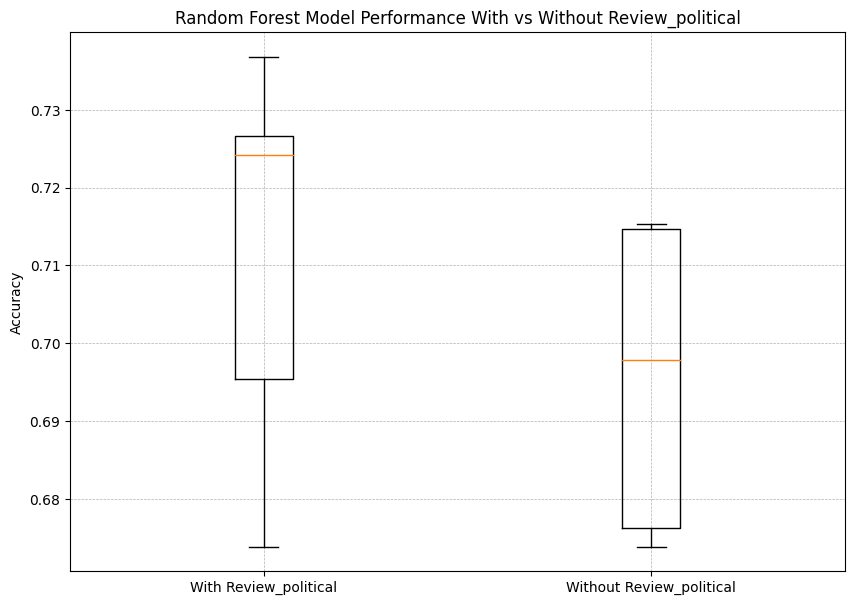

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
plt.boxplot([scores_with, scores_without], labels=['With Review_political', 'Without Review_political'])
plt.title('Random Forest Model Performance With vs Without Review_political')  # Title of the boxplot
plt.ylabel('Accuracy')  # Label for the y-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adding a grid for better readability
plt.show()  # Display the plot

In [14]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Step 1: Normality Test
_, p_value_with = shapiro(scores_with)
_, p_value_without = shapiro(scores_without)

# Use alpha=0.05 to test for normality
alpha = 0.05
if p_value_with < alpha or p_value_without < alpha:
    print("At least one of the groups does not follow a normal distribution. Proceeding with Mann-Whitney U test.")
    # Step 2A: Mann-Whitney U test for non-normal distributions
    stat, p = mannwhitneyu(scores_with, scores_without)
else:
    print("Both groups follow a normal distribution. Proceeding with t-test.")
    # Step 2B: T-test for independent samples for normal distributions
    stat, p = ttest_ind(scores_with, scores_without)

# Print the result
if p < alpha:
    print(f"Statistically significant difference found (p = {p:.4f}).")
else:
    print(f"No statistically significant difference found (p = {p:.4f}).")

Both groups follow a normal distribution. Proceeding with t-test.
No statistically significant difference found (p = 0.3127).
